In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, countDistinct, count
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "15g").getOrCreate()

In [3]:
spark

In [4]:
loans_df = spark.read.csv("df_data/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df.printSchema()

root
 |-- Min_IT_Loan_ID__c: integer (nullable = true)
 |-- Opp_Number__c: integer (nullable = true)
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: double (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [5]:
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+------------+------+-------------------+--------------------+-----+
|LoanIdFormat|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+------------+------+-------------------+--------------------+-----+
|           1|  2000|                 10|              Weekly|    4|
|           1|  2000|                 10|              Weekly|    5|
|           1|  2000|                  6|              Weekly|    4|
|           1|  1400|                 10|              Weekly|    4|
|           1|  2050|                 10|              Weekly|    4|
|           1|  2000|                 10|              Weekly|    4|
|           1|  1500|                 10|              Weekly|    4|
|           1|  2000|                 10|              Weekly|    3|
|           1|  2050|                  8|              Weekly|    3|
|           1|  2050|                 10|              Weekly|    3|
+------------+------+-------------------+--------------------+-----+
only showing top 10 rows



In [6]:
loans_df.select(["LoanIdFormat","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+-----------------+------------------+------------------+-------------------+--------------------------+--------------------+
|summary|     LoanIdFormat|             count|            Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+-----------------+------------------+------------------+-------------------+--------------------------+--------------------+
|  count|             5010|              5010|              5010|               5010|                      5010|                5010|
|   mean|8.827544910179641| 2.208982035928144|1337.9241516966067| 10.216167664670659|        22.779041916167664|  19.710578842315368|
| stddev|7.092703867623567|1.2238231995977518|1060.9889851020196|   5.70686911053265|        12.770361468751116|  12.253513797420762|
|    min|                1|                 0|               200|                  3|                         6|                 4.0|
|    max|               43|                 7|              50

In [7]:
loans_df.show(vertical=True)

-RECORD 0------------------------------------------
 Min_IT_Loan_ID__c          | 872195               
 Opp_Number__c              | 4736264              
 Id                         | 0062x00000DGh5bAAD   
 AccountID                  | 0012800001Z5quwAAB   
 Number_Of_Loans_Granted__c | 50                   
 Num_Of_Loans_Paid__c       | 44.0                 
 Purpose_of_Loan__c         | Vehicle Expenses     
 Total_Repayments__c        | 10                   
 Amount                     | 2000                 
 Term_in_Weeks__c           | 9.857                
 Payment_Frequency__c       | Weekly               
 StageName                  | Loan Paid            
 userId                     | 1319                 
 loanId                     | 1985                 
 count                      | 4                    
 LoanIdFormat               | 1                    
-RECORD 1------------------------------------------
 Min_IT_Loan_ID__c          | 5155270              
 Opp_Number_

In [8]:
hist_data  = loans_df.toPandas()

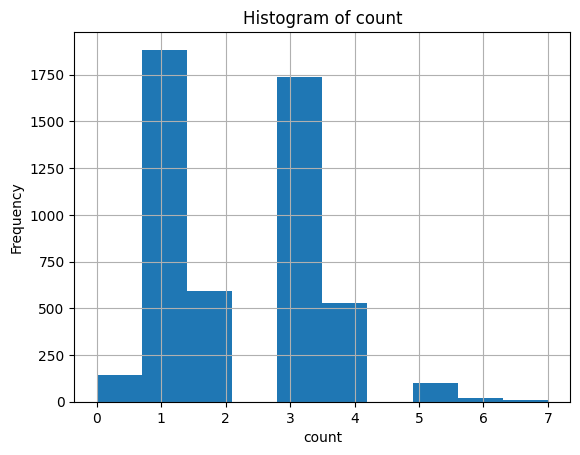

In [9]:
hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

In [10]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('LoanIdFormat').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 27
Number of unique Loan Id: 4571


In [11]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

# Count the number of unique users
# tmp = ratings_df.select('movieId').distinct().count()
# print(f"Number of unique movies: {tmp}")

Number of unique users: 2864


In [12]:
# distinct values of the rating
loans_df.select("count").distinct().show()

+-----+
|count|
+-----+
|    1|
|    6|
|    3|
|    5|
|    4|
|    7|
|    2|
|    0|
+-----+



========================================================================================================

Converting the dataset into train test and validation split.

In [13]:
# sc = spark.sparkContext

In [14]:
loans_df.select(["LoanIdFormat","count","Amount"]).show(10)

+------------+-----+------+
|LoanIdFormat|count|Amount|
+------------+-----+------+
|           1|    4|  2000|
|           1|    5|  2000|
|           1|    4|  2000|
|           1|    4|  1400|
|           1|    4|  2050|
|           1|    4|  2000|
|           1|    4|  1500|
|           1|    3|  2000|
|           1|    3|  2050|
|           1|    3|  2050|
+------------+-----+------+
only showing top 10 rows



In [15]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Min_IT_Loan_ID__c: int, Opp_Number__c: int, Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: double, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, userId: int, loanId: int, count: int, LoanIdFormat: int]

In [16]:
validation.select(["userId","loanId","LoanIdFormat","count","Amount","Total_Repayments__c"]).show()

+------+------+------------+-----+------+-------------------+
|userId|loanId|LoanIdFormat|count|Amount|Total_Repayments__c|
+------+------+------------+-----+------+-------------------+
|  1090|     6|          16|    3|  1700|                 14|
|  1284|    10|           3|    5|  2000|                  7|
|  1162|    13|          16|    3|  2300|                 16|
|   121|    22|           2|    3|  1950|                  3|
|   112|    29|           3|    3|  1300|                  7|
|   112|    29|           6|    3|  1300|                  7|
|  1138|    30|           5|    4|  1000|                  4|
|  1145|    54|           3|    4|  1500|                  7|
|  1130|    51|          16|    4|  2100|                 16|
|   361|    59|           3|    3|  1850|                  7|
|   146|    60|           5|    4|  1200|                  4|
|  1024|    73|           3|    4|  2000|                  7|
|  1571|    74|           4|    3|   350|                 10|
|  1048|

In [17]:
loans_df.printSchema()

root
 |-- Min_IT_Loan_ID__c: integer (nullable = true)
 |-- Opp_Number__c: integer (nullable = true)
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: double (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [18]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='LoanIdFormat', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)
            
            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))
            
            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)
            
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [19]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 1.0770222319300322
8 latent factors and regularization = 0.01: validation RMSE is 0.8025233240201263
8 latent factors and regularization = 0.05: validation RMSE is 0.527522726170566
8 latent factors and regularization = 0.1: validation RMSE is 0.46882131290797485
8 latent factors and regularization = 0.2: validation RMSE is 0.4874931815414786
10 latent factors and regularization = 0.001: validation RMSE is 1.3328241475799896
10 latent factors and regularization = 0.01: validation RMSE is 0.9039259654210019
10 latent factors and regularization = 0.05: validation RMSE is 0.5515210594510861
10 latent factors and regularization = 0.1: validation RMSE is 0.4794185060601832
10 latent factors and regularization = 0.2: validation RMSE is 0.49036725712159
20 latent factors and regularization = 0.001: validation RMSE is 0.8269294752310039
20 latent factors and regularization = 0.01: validation RMSE is 0.6629257898098959
20 latent fa

In [20]:
# 40 latent factors and regularization = 0.001

In [21]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [22]:
predictions.printSchema()

root
 |-- Min_IT_Loan_ID__c: integer (nullable = true)
 |-- Opp_Number__c: integer (nullable = true)
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: double (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [23]:
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(11)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|           3|   949|   858|  2000|                  7|    3|   2.83584|
|           3|  2721|  1460|  2000|                  7|    3|  2.735635|
|           6|  2915|   540|   500|                  5|    3|  2.834497|
|           2|  3190|   897|  2050|                  5|    3|  2.851729|
|           7|  1836|    31|   600|                 14|    3| 2.8237472|
|           2|  2127|  1322|  2050|                  5|    3|  2.851729|
|          13|  2644|  1270|  2200|                 20|    3| 2.8713784|
|           6|  4471|  2821|   300|                  5|    1| 0.9448323|
|           7|  3776|  2025|   200|                 12|    1| 0.9455326|
|           6|  2392|   808|   800|                  3|    3|  2.834497|
|           6|  2423|   580|   750|                

In [24]:
predictions.groupBy(predictions.prediction).count().sort(predictions.prediction).show(50)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|    5|
| 0.5921786|    1|
| 0.6478725|    2|
| 0.6785413|    1|
| 0.7150632|    1|
|0.74645513|    1|
|0.76945287|    1|
| 0.7736292|    1|
| 0.8274406|    1|
| 0.8385402|    1|
| 0.8388414|    1|
| 0.8418969|    1|
|0.86428094|    1|
| 0.8674216|    2|
| 0.8692427|    7|
|0.88774854|    1|
|0.90373975|    1|
| 0.9094535|    1|
|0.91187835|    1|
|0.91335565|    2|
|0.91818106|    1|
|0.92455125|    1|
| 0.9386798|    1|
|  0.941249|   21|
|0.94442457|   17|
| 0.9448323|    4|
| 0.9455326|    3|
|0.94635594|    2|
| 0.9465364|    2|
| 0.9471648|    1|
|0.95057636|    1|
|0.95306194|    1|
|0.95530623|    3|
| 0.9582224|    1|
| 0.9682547|    1|
|0.97168016|    1|
| 0.9736835|    1|
| 1.0104185|    5|
| 1.1580828|    1|
| 1.2016971|    1|
| 1.2578104|    1|
| 1.4183185|    1|
| 1.6761374|    1|
| 1.7233112|    1|
| 1.7463152|    2|
|  1.782915|    1|
|  1.882498|    5|
| 1.8888491|    3|
| 1.8896646|    1|
| 1.8910652|

In [25]:
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+-----------------+
|summary|        prediction|     LoanIdFormat|
+-------+------------------+-----------------+
|  count|               581|              581|
|   mean|2.5976984482418857|8.586919104991393|
| stddev|1.0085238253190267|6.719613672341118|
|    min|               0.0|                1|
|    max|          6.679113|               37|
+-------+------------------+-----------------+



In [26]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [27]:
print(f"The RMSE for the above mnodel is : {error}")

The RMSE for the above mnodel is : 0.46882131290797485


In [28]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [29]:
loanRecommends.printSchema()

root
 |-- LoanIdFormat: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [30]:
loanRecommends.select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+------------+------------------------------+-------------------------------------------------------+
|LoanIdFormat|userId                        |rating                                                 |
+------------+------------------------------+-------------------------------------------------------+
|20          |[1157, 1168, 1219, 103, 1119] |[4.499613, 3.906828, 3.7642965, 3.6192799, 3.5131187]  |
|40          |[103, 1157, 1168, 1103, 683]  |[5.8770437, 5.616664, 5.4493914, 5.3740706, 5.2649093] |
|10          |[103, 1168, 1157, 146, 106]   |[5.6706486, 5.3289933, 5.1810503, 4.916543, 4.9083853] |
|30          |[1157, 1103, 103, 1284, 1166] |[6.501194, 5.9616733, 5.94357, 5.62871, 5.62871]       |
|31          |[1168, 103, 1119, 106, 1013]  |[6.397545, 6.10162, 5.5110016, 4.857497, 4.334978]     |
|1           |[103, 1168, 1157, 1119, 106]  |[6.1580677, 6.042989, 5.319733, 5.047728, 4.9205675]   |
|21          |[1157, 1103, 1284, 1166, 1263]|[5.3761177, 4.9704947, 4.7037063, 4.7

In [31]:
# loanRecommends.filter(loanRecommends['']).select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

In [32]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [35]:
userRecommends.select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(50,truncate=False)

+------+--------------------+---------------------------------------------------------+
|userId|LoanIdFormat        |rating                                                   |
+------+--------------------+---------------------------------------------------------+
|3     |[23, 27, 13, 16, 30]|[1.2580154, 1.0961709, 1.0103939, 0.98357594, 0.97828877]|
|5     |[23, 27, 13, 16, 30]|[2.461672, 2.18268, 1.9956981, 1.960734, 1.9201549]      |
|6     |[23, 27, 13, 16, 4] |[3.2253132, 2.653228, 2.5038433, 2.4772832, 2.4182558]   |
|9     |[23, 27, 13, 16, 30]|[3.7486992, 3.2053785, 3.0174234, 2.9349818, 2.874092]   |
|13    |[23, 27, 30, 40, 9] |[2.4199972, 2.394536, 2.175098, 2.060182, 2.020837]      |
|15    |[27, 23, 30, 12, 3] |[3.6660874, 3.3004975, 3.2619295, 2.8800993, 2.849822]   |
|16    |[27, 23, 30, 12, 40]|[4.9299016, 4.5451207, 4.052986, 3.8362134, 3.8261964]   |
|17    |[23, 27, 13, 30, 16]|[3.7853613, 3.35779, 3.0338457, 2.9836323, 2.955611]     |
|19    |[23, 16, 37, 27, 13]|[2.

In [36]:
userRecommends.filter(userRecommends['userId']==182).select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(10,truncate=False)

+------+--------------------+------------------------------------------------------+
|userId|LoanIdFormat        |rating                                                |
+------+--------------------+------------------------------------------------------+
|182   |[23, 27, 16, 13, 37]|[4.3327036, 3.8358905, 3.6890879, 3.6526358, 3.577213]|
+------+--------------------+------------------------------------------------------+



In [38]:
loans_df.filter(loans_df['userId']==182).select(["userId","AccountID"]).show(10,truncate=False)

+------+------------------+
|userId|AccountID         |
+------+------------------+
|182   |0010K00001jLiLnQAK|
|182   |0010K00001jLiLnQAK|
|182   |0010K00001jLiLnQAK|
|182   |0010K00001jLiLnQAK|
+------+------------------+

